# Imports


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, cm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from ISLP.svm import plot as plot_svm
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/nhis_2022.csv')
df.head()

,YEAR,SERIAL,STRATA,PSU,NHISHID,REGION,PERNUM,NHISPID,HHX,SAMPWEIGHT,...,TOMSAUCEMNO,SODAPNO,FRIESPNO,SPORDRMNO,FRTDRINKMNO,COFETEAMNO,POTATONO,PIZZANO,HRSLEEP,CVDSHT
0,2022,1,143,16,0002022H000001,4,1,0002022H00000110,H000001,8018.0,...,2,0,110,3,0,0,3,2,8,1
1,2022,2,106,53,0002022H000003,3,1,0002022H00000310,H000003,10117.0,...,1,0,1,0,0,1,1,1,6,2
2,2022,2,106,53,0002022H000003,3,2,0002022H00000320,H000003,7933.0,...,996,996,996,996,996,996,996,996,0,2
3,2022,3,134,13,0002022H000006,2,1,0002022H00000610,H000006,2681.0,...,1,1,1,0,2,0,1,1,6,2
4,2022,4,106,53,0002022H000007,3,1,0002022H00000710,H000007,10233.0,...,3,30,5,1,0,30,6,2,8,2


# Data Cleaning
- demographic = ['AGE', 'SEX', 'BMICALC', 'EDUC', 'HINOTCOVE']
- activity = ['ALCANYNO', 'CIGDAYMO', 'MOD10DMIN', 'VIG10DMIN', 'HRSLEEP', 'HOURSWRK']
- food = ['FRUTNO', 'VEGENO', 'JUICEMNO', 'SALADSNO', 'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO', 'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO']

In [3]:
#-------- 1. Define target and feature columns --------#
target = 'DIABETICEV'

# We'll be dropping age later
feature_cols = [
    'AGE', 'BMICALC',
    'MOD10DMIN', 'PIZZANO', 'VEGENO', 'FRIESPNO', 'SALADSNO', 'SODAPNO'
]




#-------- 2. Selected features and the target --------#
df = df[feature_cols + [target]]
print(f'Current dimensions of the dataframe is: {df.shape}')

#-------- 3. Clean data --------#
# Keep only valid diabete responses (1 = No, 2 = Yes)
df_clean = df[df['DIABETICEV'].isin([1, 2])].copy()
df_clean['DIABETICEV'] = df_clean['DIABETICEV'].map({1: 0, 2: 1})  # No -> 0, Yes -> 1

df_clean = df_clean[(df_clean['AGE'] < 996.0) & (df_clean['AGE'] > 30)]  # Keep only valid ages (0–995)

# Keep only calculable BMI values (> 0 and < 996)
df_clean = df_clean[(df_clean['BMICALC'] > 0) & (df_clean['BMICALC'] < 996)]

# Replace invalid codes (996–999) with NaN
df_clean['MOD10DMIN'] = df_clean['MOD10DMIN'].where(df_clean['MOD10DMIN'] < 996, np.nan)

# Replace outliers (995–999) with NaN or drop them
food_cols = ['PIZZANO', 'VEGENO', 'FRIESPNO', 'SALADSNO', 'SODAPNO']
for col in food_cols:
    df_clean[col] = df_clean[col].where(df_clean[col] < 995, np.nan)

# Drop rows with NaNs introduced above
df_model = df_clean.dropna(subset=['BMICALC', 'MOD10DMIN', 'PIZZANO', 'VEGENO', 'FRIESPNO', 'SALADSNO', 'SODAPNO'])

#-------- 4. Display data --------#
display(df_model.reset_index(drop=True))
print(f'Current dimensions of the cleaned dataframe is: {df_model.shape}')
print(df_model['DIABETICEV'].value_counts())

Current dimensions of the dataframe is: (35115, 9)


,AGE,BMICALC,MOD10DMIN,PIZZANO,VEGENO,FRIESPNO,SALADSNO,SODAPNO,DIABETICEV
0,61,38.4,0.0,2.0,15.0,110.0,10.0,0.0,0
1,43,27.3,20.0,1.0,1.0,1.0,1.0,0.0,0
2,68,25.0,60.0,1.0,1.0,1.0,1.0,1.0,0
3,73,24.0,690.0,2.0,4.0,5.0,4.0,30.0,0
4,73,26.5,60.0,1.0,2.0,3.0,5.0,5.0,0
...,...,...,...,...,...,...,...,...,...
20618,78,20.5,0.0,3.0,0.0,2.0,4.0,0.0,0
20619,45,31.4,120.0,2.0,30.0,4.0,10.0,0.0,0
20620,47,36.3,45.0,1.0,2.0,1.0,1.0,0.0,0
20621,37,29.0,30.0,2.0,1.0,1.0,5.0,4.0,0


Current dimensions of the cleaned dataframe is: (20623, 9)
DIABETICEV
0    18165
1     2458
Name: count, dtype: int64


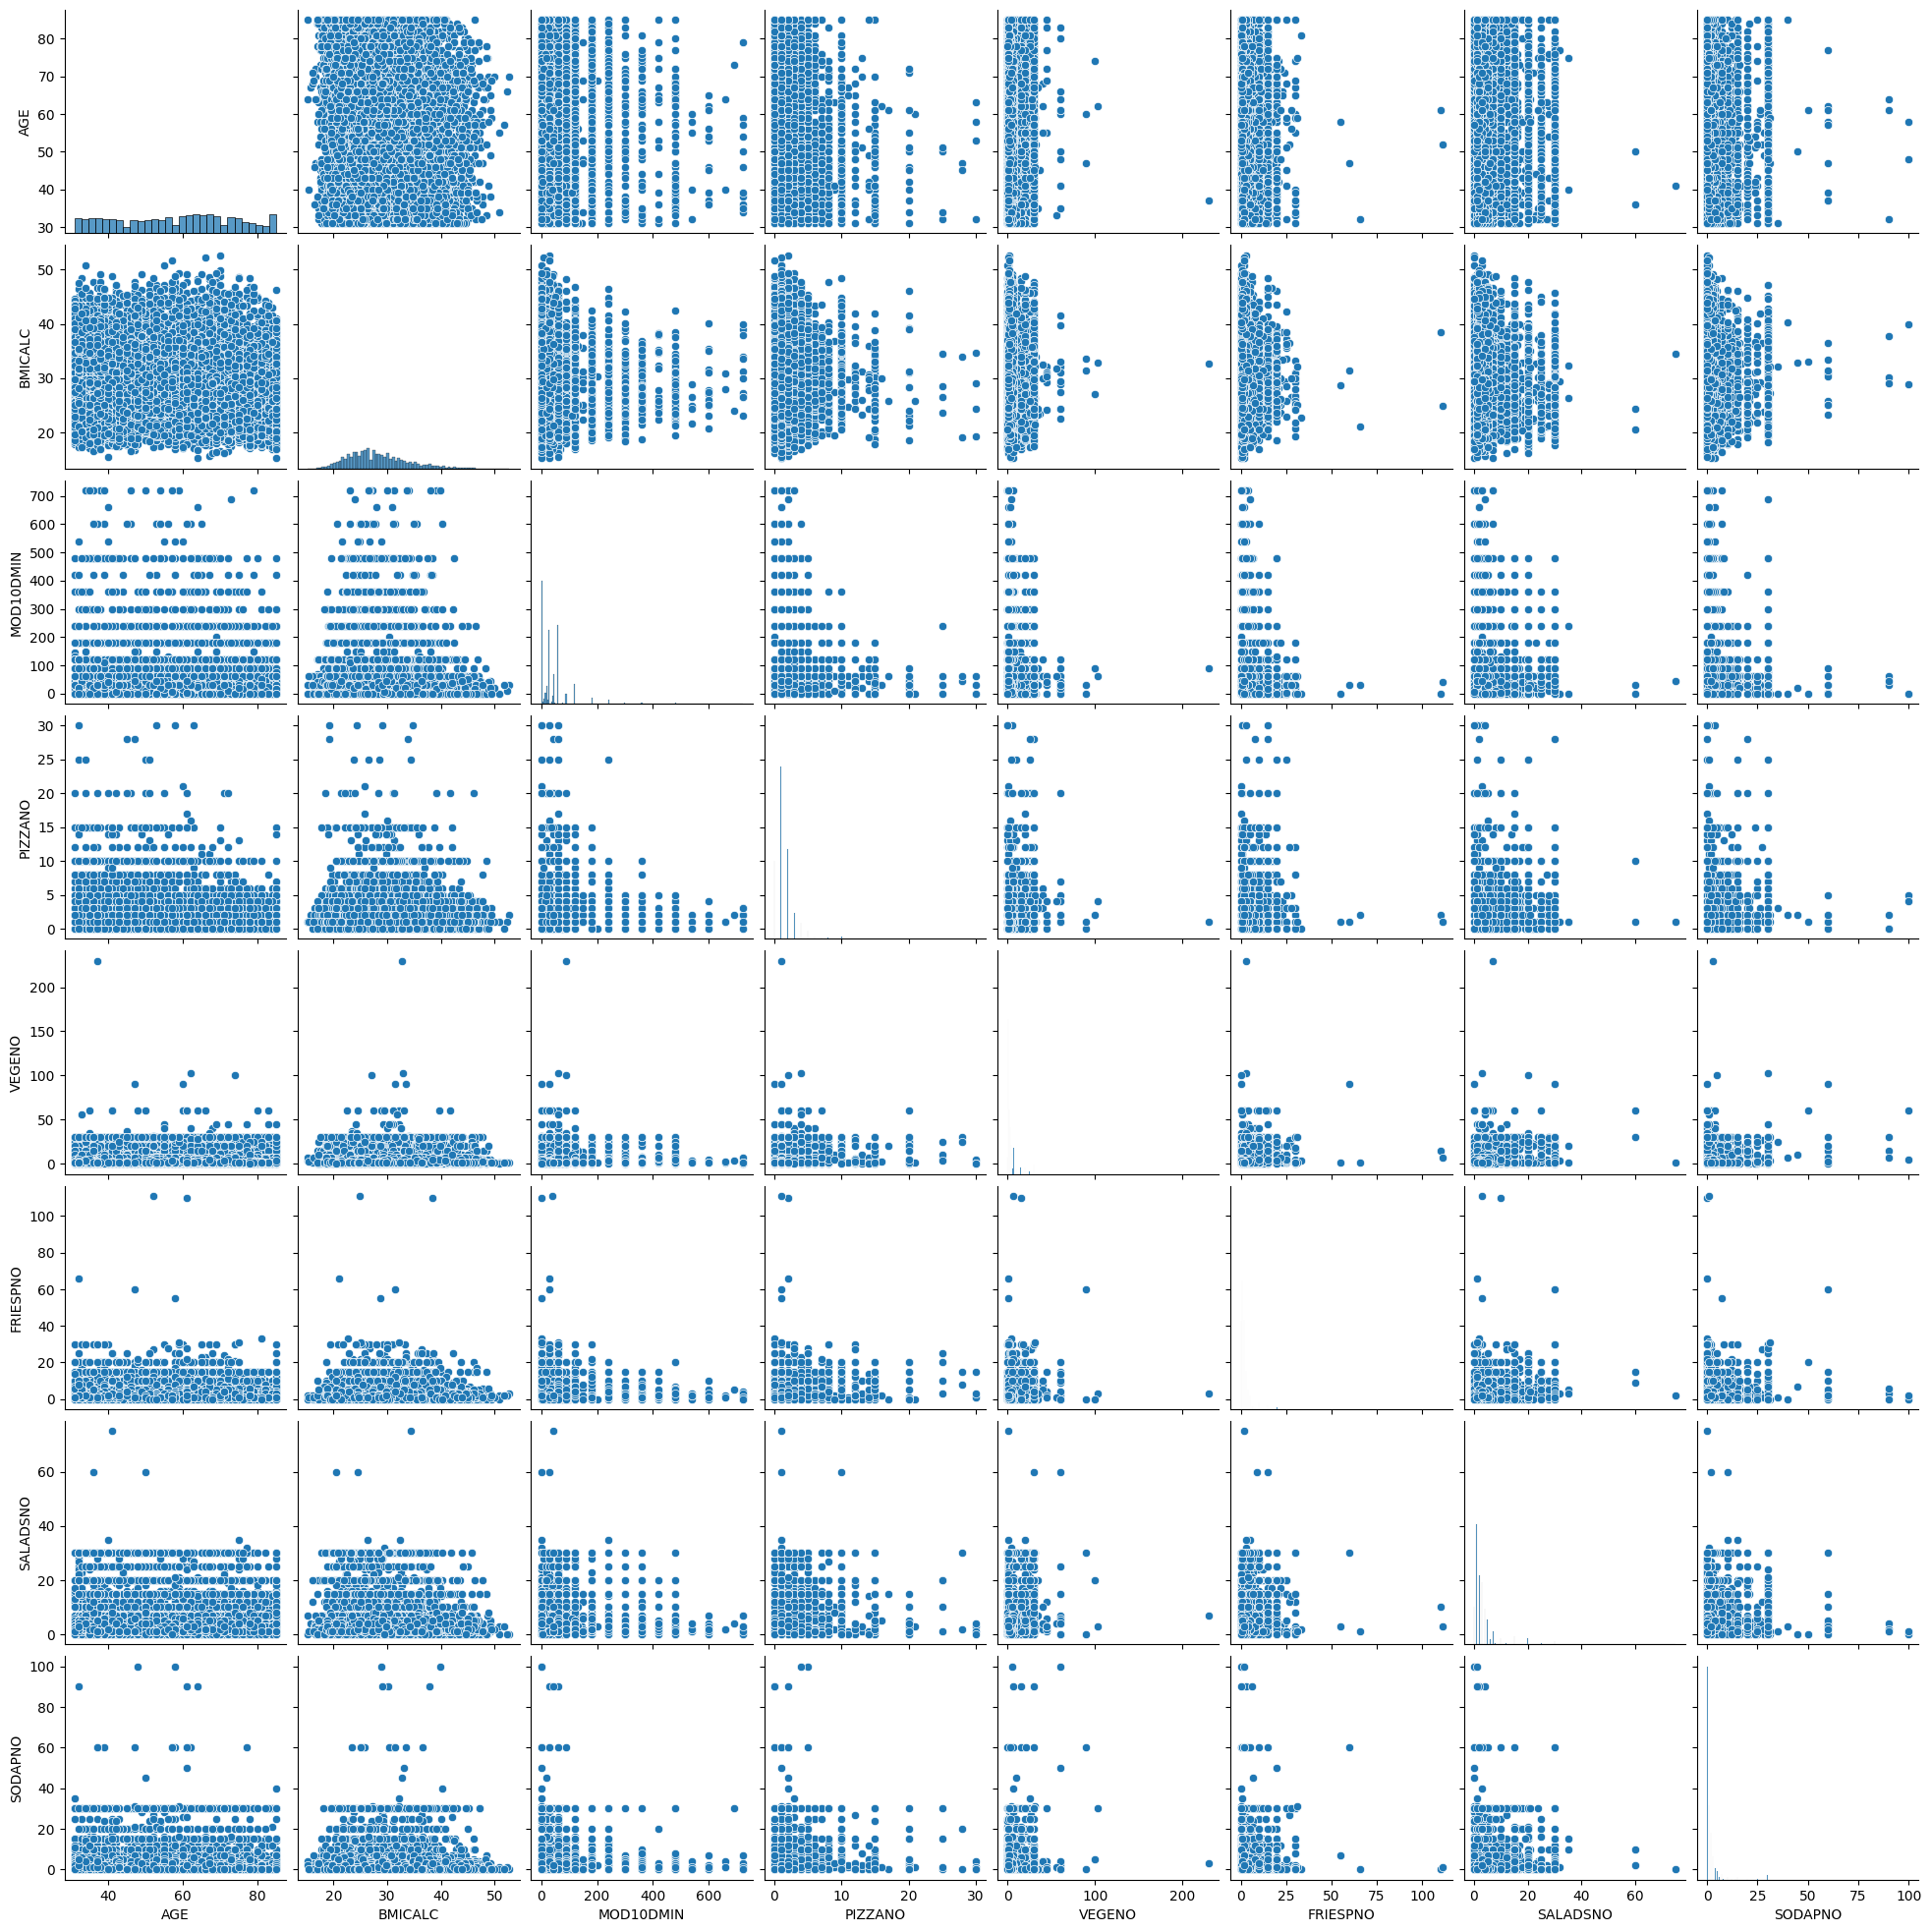

In [4]:
import seaborn as sns

# Quick pairplot
sns.pairplot(df_model[['AGE', 'BMICALC', 'MOD10DMIN', 'PIZZANO', 'VEGENO', 'FRIESPNO', 'SALADSNO', 'SODAPNO']],)
plt.show()

# Data Setup & Comments
I have cleaned out all of the data that was labeled as "Unknown" in any type of format according to the Codebook. <br>

Also, if you look at the class distribution of STROKEV, you can see that there is a heavy data imbalance of 21604 "no" cases vs 2496 "yes" cases. Something to keep in mind moving forward.

# Linear Model

In [6]:
# Select features
features_linear = ['BMICALC', 'MOD10DMIN']

# features_linear = ['AGE', 'BMICALC', 'MOD10DMIN', 'SODAPNO', 'VEGENO']
X = df_model[features_linear ]
y = df_model['DIABETICEV']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize model
linear_svm = SVC(kernel='linear')

# Grid Search for Linear SVM
param_grid_linear = {'C': [0.1, 1, 5, 10]}

grid_linear = GridSearchCV(linear_svm, param_grid_linear, cv=5, scoring='accuracy')
grid_linear.fit(X_train_scaled, y_train)

# Best model
best_linear = grid_linear.best_estimator_

# Evaluate
y_pred_linear = best_linear.predict(X_test_scaled)

#--------------- Metrics ---------------#

# Mean Test Error
mean_test_error_linear = 1 - grid_linear.best_score_

# AUC-ROC (Model's discrimination power across all thresholds)
y_scores = best_linear.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

# Precision-Recall (Class Imbalance)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

print("Linear SVM Results:")
print(classification_report(y_test, y_pred_linear))
print(confusion_matrix(y_test, y_pred_linear))
print(f"best C: {grid_linear.best_params_['C']}")
print(f"Mean CV Test Error (Linear): {mean_test_error_linear:.4f}")
print(f"AUC Score (Linear): {auc_score:.4f}")
print(f"Average Precision Score (Linear): {avg_precision:.4f}")
print(f"Precision: {precision.mean():.4f}, Recall: {recall.mean():.4f}")


Linear SVM Results:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3638
           1       0.00      0.00      0.00       493

    accuracy                           0.88      4131
   macro avg       0.44      0.50      0.47      4131
weighted avg       0.78      0.88      0.82      4131

[[3638    0]
 [ 493    0]]
best C: 0.1
Mean CV Test Error (Linear): 0.1193
AUC Score (Linear): 0.6315
Average Precision Score (Linear): 0.1790
Precision: 0.1719, Recall: 0.5522


c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

# Plots
1. AUC-ROC
2. Precision Recall
3. SVM

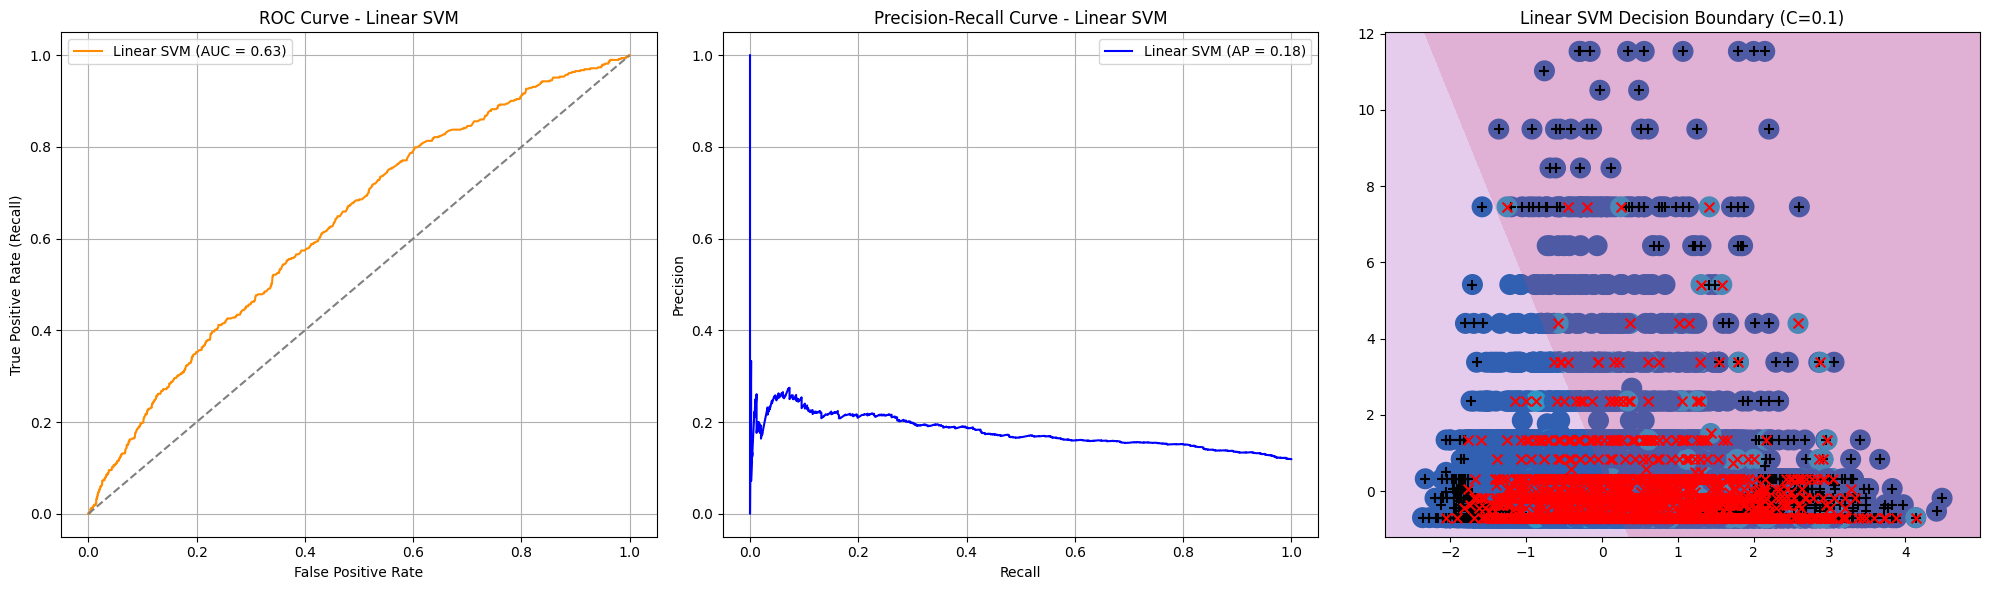

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ----- ROC Curve -----
axes[0].plot(fpr, tpr, label=f"Linear SVM (AUC = {auc_score:.2f})", color='darkorange')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].set_title("ROC Curve - Linear SVM")
axes[0].legend()
axes[0].grid(True)

# ----- Precision-Recall Curve -----
axes[1].plot(recall, precision, label=f"Linear SVM (AP = {avg_precision:.2f})", color='blue')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve - Linear SVM")
axes[1].legend()
axes[1].grid(True)

# ----- SVM Decision Boundary -----
# If using ISLP's plot_svm
plot_svm(X_train_scaled, y_train.reset_index(drop=True), best_linear, scatter_cmap=cm.tab10, ax=axes[2])
axes[2].set_title(f"Linear SVM Decision Boundary (C={best_linear.C})")

# Final layout tweaks
plt.tight_layout()
plt.show()

# Polynomial Model

In [11]:
# Select features
features_poly = ['PIZZANO', 'VEGENO', 'FRIESPNO', 'SALADSNO', 'SODAPNO']
X = df_model[features_poly]
y = df_model['DIABETICEV']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize model
poly_svm = SVC(kernel='poly')

# Grid Search for Poly SVM
param_grid_poly = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1],
    'degree': [2, 3]
}

grid_poly = GridSearchCV(poly_svm, param_grid_poly, cv=3, scoring='accuracy')
grid_poly.fit(X_train_scaled, y_train)

# Best model
best_poly = grid_poly.best_estimator_

# Evaluate
y_pred_poly = best_poly.predict(X_test_scaled)

# Mean Test Error
mean_test_error_poly = 1 - grid_poly.best_score_

# AUC-ROC (Model's discrimination power across all thresholds)
y_scores = best_poly.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

# Precision-Recall (Class Imbalance)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

print("Polynomial SVM Results:")
print(classification_report(y_test, y_pred_poly))
print(confusion_matrix(y_test, y_pred_poly))
print(f"best C: {grid_poly.best_params_['C']}")
print(f"best gamma: {grid_poly.best_params_['gamma']}")
print(f"best degree: {grid_poly.best_params_['degree']}")
print(f"Mean CV Test Error (Polynomial): {mean_test_error_poly:.4f}")
print(f"AUC Score (Polynomial): {auc_score:.4f}")
print(f"Average Precision Score (Polynomial): {avg_precision:.4f}")
print(f"Precision: {precision.mean():.4f}, Recall: {recall.mean():.4f}")

Polynomial SVM Results:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3633
           1       0.00      0.00      0.00       492

    accuracy                           0.88      4125
   macro avg       0.44      0.50      0.47      4125
weighted avg       0.78      0.88      0.82      4125

[[3633    0]
 [ 492    0]]
best C: 0.001
best gamma: 0.001
best degree: 2
Mean CV Test Error (Polynomial): 0.1192
AUC Score (Polynomial): 0.4544
Average Precision Score (Polynomial): 0.1048
Precision: 0.1025, Recall: 0.4850


c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

# Plots
1. AUC-ROC
2. Precision Recall
3. SVM

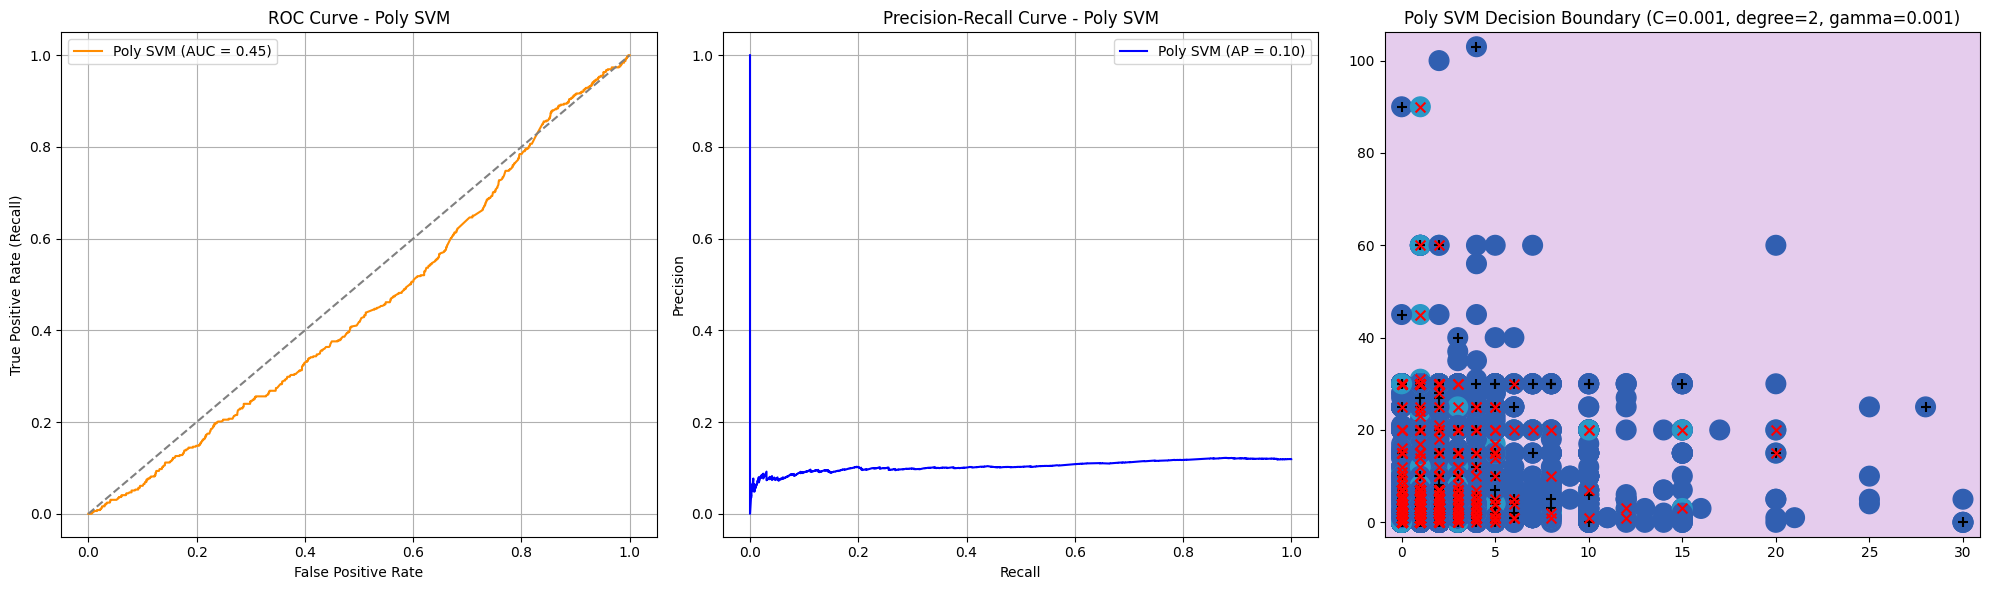

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ----- ROC Curve -----
axes[0].plot(fpr, tpr, label=f"Poly SVM (AUC = {auc_score:.2f})", color='darkorange')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].set_title("ROC Curve - Poly SVM")
axes[0].legend()
axes[0].grid(True)

# ----- Precision-Recall Curve -----
axes[1].plot(recall, precision, label=f"Poly SVM (AP = {avg_precision:.2f})", color='blue')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve - Poly SVM")
axes[1].legend()
axes[1].grid(True)

# ----- SVM Decision Boundary -----
# If using ISLP's plot_svm
plot_svm(X_train, y_train.reset_index(drop=True), best_poly, scatter_cmap=cm.tab10, ax=axes[2])
axes[2].set_title(f"Poly SVM Decision Boundary (C={best_poly.C}, degree={best_poly.degree}, gamma={best_poly.gamma})")

# Final layout tweaks
plt.tight_layout()
plt.show()

# RBF Model

In [14]:
# Select features
features_rbf = ['BMICALC', 'PIZZANO', 'VEGENO', 'FRIESPNO', 'MOD10DMIN']
X = df_model[features_rbf]
y = df_model['DIABETICEV']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Grid Search for RBF SVM
param_grid_rbf = {
    'C': [0.001, 0.01, 0.1, 1],
    'gamma': [0.001, 0.01, 0.1, 1],
}

rbf_svm = SVC(kernel='rbf')

grid_rbf = GridSearchCV(rbf_svm, param_grid_rbf, cv=5, scoring='accuracy')
grid_rbf.fit(X_train_scaled, y_train)

# Best model
best_rbf = grid_rbf.best_estimator_

# Evaluate
y_pred_rbf = best_rbf.predict(X_test_scaled)

# Mean Test Error
mean_test_error_rbf = 1 - grid_rbf.best_score_

# AUC-ROC (Model's discrimination power across all thresholds)
y_scores = best_rbf.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

# Precision-Recall (Class Imbalance)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

print("RBF SVM Results:")
print(classification_report(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))
print(f"best C: {grid_rbf.best_params_['C']}")
print(f"best gamma: {grid_poly.best_params_['gamma']}")
print(f"Mean CV Test Error (RBF): {mean_test_error_rbf:.4f}")
print(f"AUC Score (RBF): {auc_score:.4f}")
print(f"Average Precision Score (RBF): {avg_precision:.4f}")
print(f"Precision: {precision.mean():.4f}, Recall: {recall.mean():.4f}")

RBF SVM Results:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3633
           1       0.00      0.00      0.00       492

    accuracy                           0.88      4125
   macro avg       0.44      0.50      0.47      4125
weighted avg       0.78      0.88      0.82      4125

[[3633    0]
 [ 492    0]]
best C: 0.001
best gamma: 0.001
Mean CV Test Error (RBF): 0.1192
AUC Score (RBF): 0.5438
Average Precision Score (RBF): 0.1287
Precision: 0.1273, Recall: 0.5308


c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

# Plots
1. AUC-ROC
2. Precision Recall
3. SVM

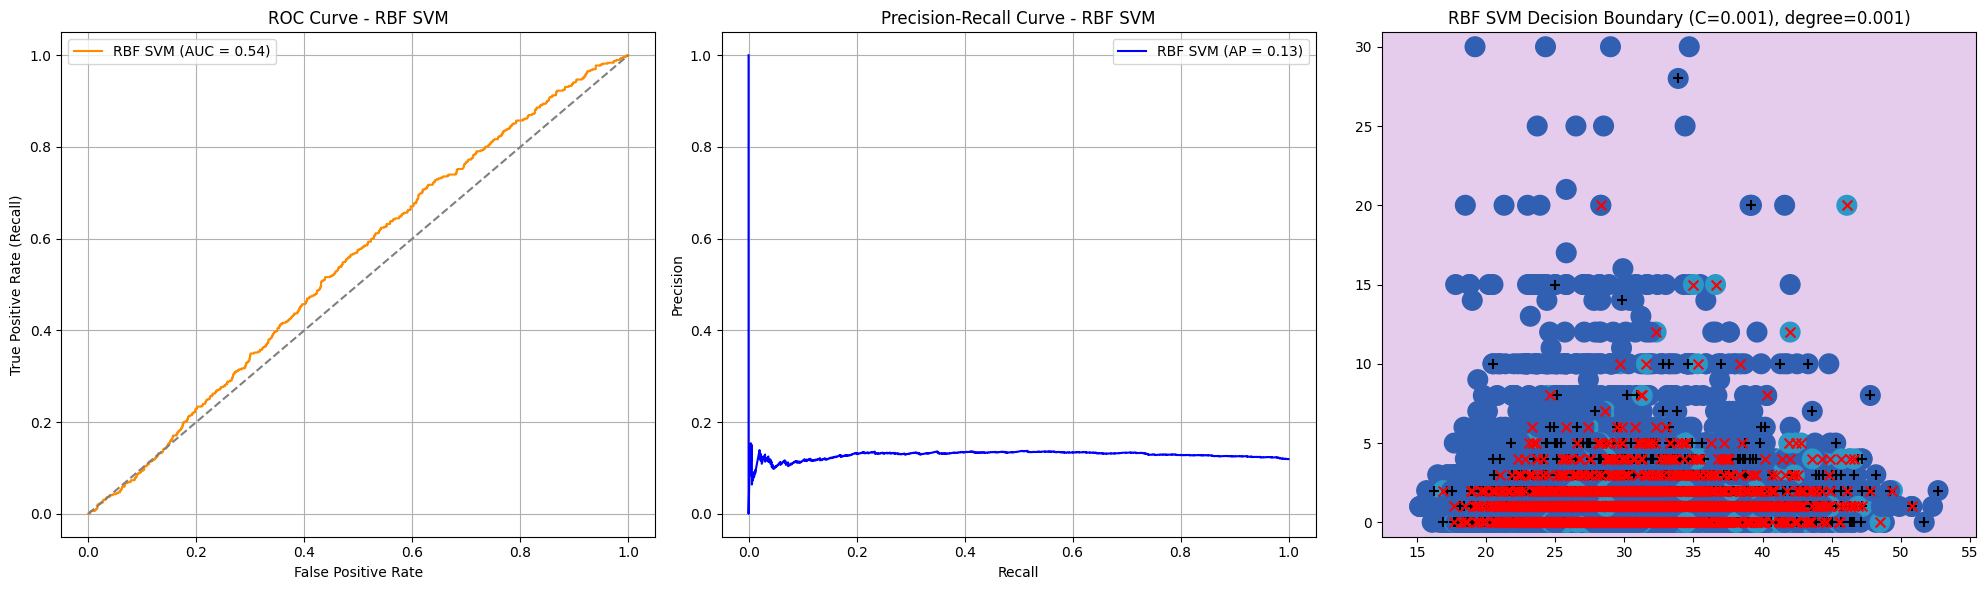

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ----- ROC Curve -----
axes[0].plot(fpr, tpr, label=f"RBF SVM (AUC = {auc_score:.2f})", color='darkorange')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate (Recall)")
axes[0].set_title("ROC Curve - RBF SVM")
axes[0].legend()
axes[0].grid(True)

# ----- Precision-Recall Curve -----
axes[1].plot(recall, precision, label=f"RBF SVM (AP = {avg_precision:.2f})", color='blue')
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve - RBF SVM")
axes[1].legend()
axes[1].grid(True)

# ----- SVM Decision Boundary -----
# If using ISLP's plot_svm
plot_svm(X_train, y_train.reset_index(drop=True), best_rbf, ax=axes[2])
axes[2].set_title(f"RBF SVM Decision Boundary (C={best_rbf.C}), degree={best_rbf.gamma})")

# Final layout tweaks
plt.tight_layout()
plt.show()